C:\Users\chira.AMCS\AppData\Local\Temp\ipykernel_14840\2055285683.py:10: DtypeWarning: Columns (5,10,11,17,18,19,44,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,79,90,101,112,115,119,122,123,126,130,133,134,137,141,144,148,152,155) have mixed types. Specify dtype option on import or set low_memory=False.
  ncr_data = pd.read_csv('ncr.csv',lineterminator='\n')


Index(['latitude', 'longitude', 'Total Population'], dtype='object')


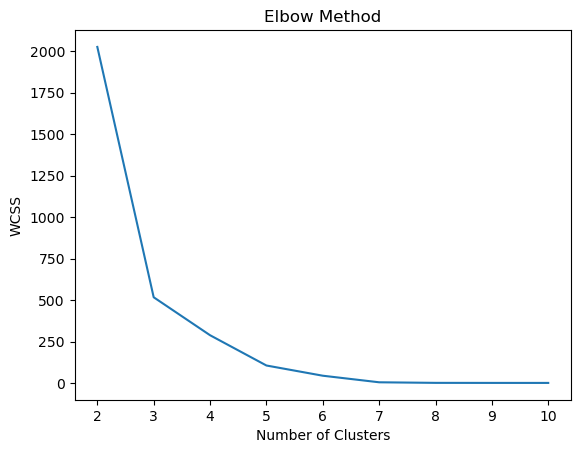

Increasing Cluster No indicates higher demand


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# load NCR dataset
ncr_data = pd.read_csv('ncr.csv',lineterminator='\n')

# load UK census dataset
census_data = pd.read_csv('datadownload (2).csv', dtype={'Total Population': float}).dropna()

# preprocess NCR dataset

ncr_data.rename(columns={'town': 'Neighborhood'}, inplace=True)

# preprocess UK census dataset
census_data = census_data[census_data['Unnamed: 1'].str.startswith('E')]
census_data['Total Population'] = census_data.iloc[:, 3:].sum(axis=1)
census_data.drop(census_data.columns[3:-1], axis=1, inplace=True)
census_data.rename(columns={'Unnamed: 1': 'Neighborhood', 'Unnamed: 0': 'Code'}, inplace=True)

# merge datasets
merged_data = pd.merge(ncr_data, census_data, on='Neighborhood')
merged_data = merged_data[['latitude', 'longitude', 'Total Population']]
merged_data['Total Population'] = merged_data['Total Population'].astype(int)

# standardize data
print(merged_data.columns)


# use elbow method to determine optimal number of clusters
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(merged_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# use k-means clustering to cluster neighborhoods
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(merged_data)

# create map
uk_map = folium.Map(location=[53.4084, -2.9916], zoom_start=8)

# create cluster colors dictionary
cluster_colors = {0: 'blue', 1: 'green', 2: 'red'}


# add markers to map
for lat, lng, population, cluster in zip(merged_data['latitude'], merged_data['longitude'], merged_data['Total Population'], clusters):
    label = folium.Popup(str(population) + ' lakh people, Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue' if cluster == 0 else 'green' if cluster == 1 else 'red',
        fill=True,
        fill_color='blue' if cluster == 0 else 'green' if cluster == 1 else 'red',
        fill_opacity=0.7).add_to(uk_map)
# create legend control
legend_html = """
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 120px; height: 120px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:rgba(255, 255, 255, 0.8);
                ">
     <p style="margin:10px">Cluster 0: <span style='color:blue;'>Blue</span></p>
     <p style="margin:10px">Cluster 1: <span style='color:green;'>Green</span></p>
     <p style="margin:10px">Cluster 2: <span style='color:red;'>Red</span></p>
     </div>
     """

uk_map.get_root().html.add_child(folium.Element(legend_html))
print("Increasing Cluster No indicates higher demand")
# display map
uk_map.save(r'C:\DT\map.html')
uk_map
